# Audiobook churn

IMPORT

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, plot_confusion_matrix, classification_report, precision_recall_curve
import matplotlib.pyplot as plt
from imblearn.combine import SMOTETomek
import xgboost as xgb

In [2]:
names = ['ID','Book_length_total','Book_length_avg', 'Price_total','Price_avg', 'Review', 'Review_rating', 'Minutes_listened', 'Completion', 'Support_req', 'Last_visit', 'Target']

In [3]:
raw_data = pd.read_csv('Audiobooks_data.csv', names=names)
raw_data.shape

(14084, 12)

In [4]:
raw_data.head()

,ID,Book_length_total,Book_length_avg,Price_total,Price_avg,Review,Review_rating,Minutes_listened,Completion,Support_req,Last_visit,Target
0,873,2160.0,2160,10.13,10.13,0,8.91,0.0,0.0,0,0,1
1,611,1404.0,2808,6.66,13.33,1,6.50,0.0,0.0,0,182,1
2,705,324.0,324,10.13,10.13,1,9.00,0.0,0.0,1,334,1
3,391,1620.0,1620,15.31,15.31,0,9.00,0.0,0.0,0,183,1
4,819,432.0,1296,7.11,21.33,1,9.00,0.0,0.0,0,0,1


In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14084 entries, 0 to 14083
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 14084 non-null  int64  
 1   Book_length_total  14084 non-null  float64
 2   Book_length_avg    14084 non-null  int64  
 3   Price_total        14084 non-null  float64
 4   Price_avg          14084 non-null  float64
 5   Review             14084 non-null  int64  
 6   Review_rating      14084 non-null  float64
 7   Minutes_listened   14084 non-null  float64
 8   Completion         14084 non-null  float64
 9   Support_req        14084 non-null  int64  
 10  Last_visit         14084 non-null  int64  
 11  Target             14084 non-null  int64  
dtypes: float64(6), int64(6)
memory usage: 1.3 MB


In [6]:
#### USED TO TEST FOR NAN VALUES
test_nan = raw_data
null_columns = test_nan.columns[test_nan.isnull().any()]

test_nan[null_columns].isnull().sum()
print(test_nan[test_nan.isnull().any(axis=1)][null_columns].head())

Empty DataFrame
Columns: []
Index: []


In [7]:
#Let's test the dataset for imbalance in targets
positive = sum(raw_data['Target'])
print(f'There are {positive} returning customers and {raw_data.shape[0]-positive} non-returning customers')

There are 2237 returning customers and 11847 non-returning customers


In [8]:
#There is some imbalance which we will correct
X = raw_data.iloc[:,:-1]
y = raw_data.iloc[:,-1]

smt = SMOTETomek(random_state=42)
X_smt, y_smt = smt.fit_resample(X, y)

In [9]:
#Lets test the balance again
positive = sum(y_smt)
print(f'There is {positive} returning customers and {y_smt.shape[0]-positive} non-returning customers')

There is 10653 returning customers and 10653 non-returning customers


In [10]:
print(X_smt.shape, y_smt.shape)

(21306, 11) (21306,)


In [11]:
#Now we split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X_smt, y_smt, test_size=0.2)

In [12]:
#Here we calculate metrics for the different algorithms and store the results in a dictionary for later comparison of the results
metrics_dict = dict()

def metrics(grid, X_test, y_test, label):
    global metrics_dict
    
    y_test_scores = grid.predict(X_test)
    lr_probs = grid.predict_proba(X_test)[:,1]
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
    roc_auc = roc_auc_score(y_test, lr_probs)
    
    
    print(f'BEST PARAMS ARE: {grid.best_params_}')
    print(f'SCORE: {grid.score(X_test, y_test)}')
    print(f'ROC AUC SCORE: {roc_auc_score(y_test, lr_probs):.2f}')
    print(classification_report(y_test, y_test_scores))
    
    print(f'CONFUSION MATRIX: {confusion_matrix(y_test, y_test_scores)}')
    
    #CONFUSION MATRIX PLOT
    plt.style.use('seaborn-white')
    plot_confusion_matrix(grid, X_test, y_test)
    
    fig1, ax1 = plt.subplots()
    fig2, ax2 = plt.subplots()
    
    
    #ROC AUC CURVE
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    #ax1.set_facecolor('w')
    ax1.plot(lr_fpr, lr_tpr, label=label, linewidth=2)
    # axis labels
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    # show the legend

    metrics_dict[label] = {'precision': lr_precision, 'recall': lr_recall, 'false_positives': lr_fpr, 'true_positives': lr_tpr, 'auc': roc_auc}
    
    #PRECISION RECALL PLOT
    #ax2.set_facecolor('w')
    ax2.plot(lr_recall, lr_precision, label=label, linewidth=2)
    # axis labels
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    # show the legend
    plt.legend()
    
    # show the plot
    plt.show()
    return roc_auc, lr_precision, lr_recall

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    1.5s remaining:    1.3s
[Parallel(n_jobs=12)]: Done  15 out of  15 | elapsed:    1.6s finished


BEST PARAMS ARE: {'logistic__C': 1}
SCORE: 0.830830595964336
ROC AUC SCORE: 0.92
              precision    recall  f1-score   support

           0       0.80      0.89      0.84      2161
           1       0.87      0.77      0.82      2101

    accuracy                           0.83      4262
   macro avg       0.84      0.83      0.83      4262
weighted avg       0.83      0.83      0.83      4262

CONFUSION MATRIX: [[1922  239]
 [ 482 1619]]


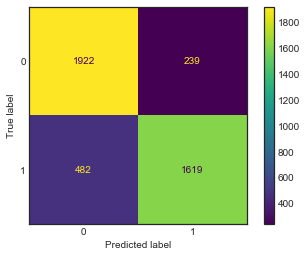

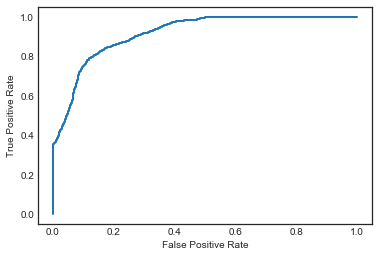

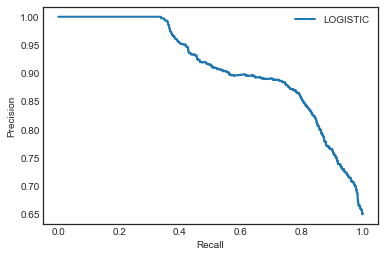

In [13]:
scaler = StandardScaler()
logistic = LogisticRegression()
pipe = Pipeline(steps=[('scaler', scaler),('logistic', logistic)])
param_grid = {
    'logistic__C': [.1, 1, .01]
}
grid = GridSearchCV(pipe, param_grid, cv=5, verbose=2, n_jobs=12)
grid.fit(X_train, y_train)

log_roc_auc, log_precision, log_recall = metrics(grid, X_test, y_test, 'LOGISTIC')

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   33.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  4.0min
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:  6.2min finished


BEST PARAMS ARE: {'xgb__colsample_bytree': 0.9, 'xgb__gamma': 0, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 10, 'xgb__n_estimators': 400, 'xgb__reg_alpha': 0.1, 'xgb__subsample': 0.9}
SCORE: 0.9347724073205068
ROC AUC SCORE: 0.98
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      2161
           1       0.93      0.94      0.93      2101

    accuracy                           0.93      4262
   macro avg       0.93      0.93      0.93      4262
weighted avg       0.93      0.93      0.93      4262

CONFUSION MATRIX: [[2012  149]
 [ 129 1972]]


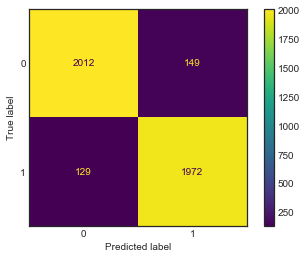

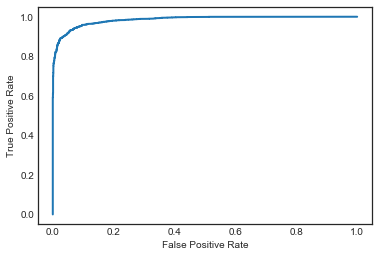

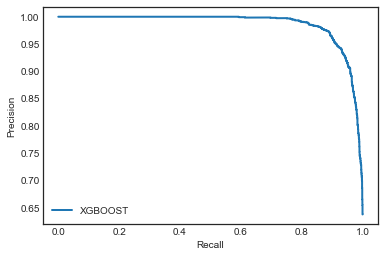

In [14]:
#XGBoost      
scaler = StandardScaler()
xgb = xgb.XGBClassifier(random_state=42)#, tree_method='gpu_hist', gpu_id=0, predictor = 'gpu_predictor', sampling_method='gradient_based'
pipe = Pipeline(steps=[('scaler', scaler),('xgb', xgb)])
param_grid = {
    'xgb__learning_rate': [0.1],
    'xgb__n_estimators': range(400,800,100),
    'xgb__max_depth': range(6,16,2),
    'xgb__gamma': [0],
    'xgb__subsample': [0.8,0.9],
    'xgb__colsample_bytree': [0.9],
    'xgb__reg_alpha': [0.1]
}
grid = GridSearchCV(pipe, param_grid, cv=5, verbose=2, n_jobs=8)
grid.fit(X_train, y_train)
xgb_roc_auc, xgb_precision, xgb_recall = metrics(grid, X_test, y_test, 'XGBOOST')

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   10.4s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Done 320 out of 320 | elapsed:  3.6min finished


BEST PARAMS ARE: {'rfc__criterion': 'gini', 'rfc__max_depth': 20, 'rfc__min_samples_split': 2, 'rfc__n_estimators': 400}
SCORE: 0.9110746128578132
ROC AUC SCORE: 0.98
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      2161
           1       0.90      0.92      0.91      2101

    accuracy                           0.91      4262
   macro avg       0.91      0.91      0.91      4262
weighted avg       0.91      0.91      0.91      4262

CONFUSION MATRIX: [[1948  213]
 [ 166 1935]]


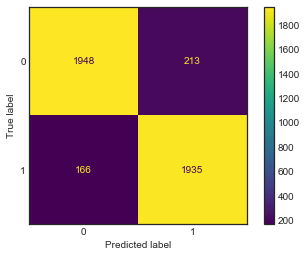

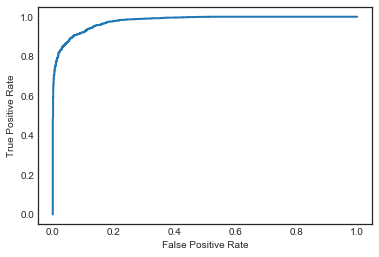

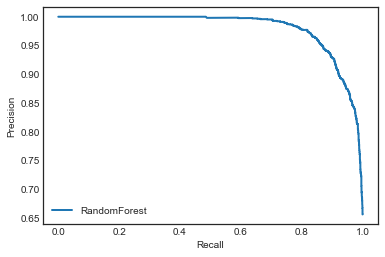

In [15]:
rfc = RandomForestClassifier(random_state=42, n_jobs=8)# , tree_method='gpu_hist', gpu_id=0, predictor = 'gpu_predictor', sampling_method='gradient_based'
pipe = Pipeline(steps=[('scaler', scaler),('rfc', rfc)])
param_grid = {
    'rfc__n_estimators': range(400,800,100),
    'rfc__max_depth': range(5,25,5),
    'rfc__criterion': ['gini','entropy'],
    'rfc__min_samples_split': [2,5],
}

grid = GridSearchCV(pipe, param_grid, cv=5, verbose=2, n_jobs=8)
grid.fit(X_train, y_train)

rfc_roc_auc, rfc_precision, rfc_recall = metrics(grid, X_test, y_test, 'RandomForest')

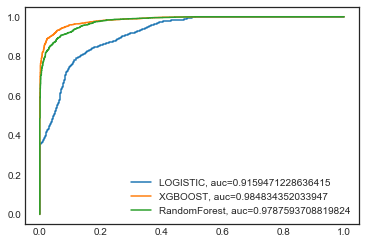

In [24]:
#plt.figure(0).clf()
for algo in metrics_dict:
    plt.plot(metrics_dict[algo]['false_positives'],metrics_dict[algo]['true_positives'],label=str(algo)+", auc="+str(metrics_dict[algo]['auc']))
plt.legend()
plt.show()

__As we can see in the abouve ROC AUC curve, the best performing algorith is XGBoost__